***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [6]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)
df_html.head()

Shape of our dataset: (43491, 1433)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_ftp,a_href_https,a_href_irc,a_href_mailto,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,a_rel_designer,a_rel_detalis,a_rel_discussion,a_rel_dofollow,...,object_data_.svg,object_data_.swf,object_data_absolute,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,pro

In [7]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)


df_js.drop(['js_function_Object.defineProperty(',
'js_function_Object.keys(',
'js_function_.substr',
'js_function_unescape('],axis=1,inplace=True)
print("Shape of our dataset:",df_js.shape)
df_js.head()

Shape of our dataset: (43294, 397)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [21]:
fin_col=['script_count','div_count','a_count','link_href_absolute','script_src_relative','script_src_out_of_domain',
        'script_type_text/javascript','img_src_absolute','img_src_out_of_domain','meta_http-equiv_X-UA-Compatible',
        'iframe_src_relative','iframe_count','js_function_.replace(','dom_function_window.addEventListener(',
         'js_function_.concat(','dom_function_document.createElement(','js_function_encodeURIComponent(',
        'js_function_.substring(','js_function_decodeURIComponent(','js_function_.charAt(']

In [22]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 21)

In [23]:
df_sel.head()

,script_count,div_count,a_count,link_href_absolute,script_src_relative,script_src_out_of_domain,script_type_text/javascript,img_src_absolute,img_src_out_of_domain,meta_http-equiv_X-UA-Compatible,iframe_src_relative,iframe_count,js_function_.replace(,dom_function_window.addEventListener(,js_function_.concat(,dom_function_document.createElement(,js_function_encodeURIComponent(,js_function_.substring(,js_function_decodeURIComponent(,js_function_.charAt(,Target
domain,,,,,,,,,,,,,,,,,,,,,
h83.turdizi.com,10.0,17.0,3.0,3.0,8.0,2.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Malicious
hbgv.wivela.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,Malicious
nus.edu.sg,25.0,256.0,167.0,14.0,19.0,18.0,22.0,29.0,29.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,Non_Malicious
arabwebpage.com,19.0,156.0,170.0,13.0,10.0,2.0,9.0,42.0,42.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Non_Malicious
moscatalogue.net,11.0,270.0,127.0,22.0,5.0,2.0,0.0,46.0,29.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Non_Malicious


In [24]:
df_sel.Target=df_sel.Target.apply(lambda x: 1 if x=='Malicious' else 0)

In [25]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [26]:
fin_col

['script_count',
 'div_count',
 'a_count',
 'link_href_absolute',
 'script_src_relative',
 'script_src_out_of_domain',
 'script_type_text/javascript',
 'img_src_absolute',
 'img_src_out_of_domain',
 'meta_http-equiv_X-UA-Compatible',
 'iframe_src_relative',
 'iframe_count',
 'js_function_.replace(',
 'dom_function_window.addEventListener(',
 'js_function_.concat(',
 'dom_function_document.createElement(',
 'js_function_encodeURIComponent(',
 'js_function_.substring(',
 'js_function_decodeURIComponent(',
 'js_function_.charAt(',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [27]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [28]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.892897718549
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24810  3028    27838
True         460  4269     4729
__all__    25270  7297    32567

Accuracy of the model for test data is: 0.888847948907
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6172   768     6940
True         137  1065     1202
__all__     6309  1833     8142



Logistic Regression
Accuracy of the model for training data is: 0.854361777259
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27809    29    27838
True        4714    15     4729
__all__    32523    44    32567

Accuracy of the model for test data is: 0.851879145173
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6931     9     6940
True        1197     5     1202
__all__     8128    14     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.903951853103
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24870  2968    27838
True         160  4569     4729
__all__    25030  7537    32567

Accuracy of the model for test data is: 0.893269466961
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6190   750     6940
True         119  1083     1202
__all__     6309  1833     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.874811926183
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24637  3201    27838
True         876  3853     4729
__all__    25513  7054    32567

Accuracy of the model for test data is: 0.876688774257
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6151   789     6940
True         215   987     1202
__all__     6366  1776     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.889182301102
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24923  2915    27838
True         694  4035     4729
__all__    25617  6950    32567

Accuracy of the model for test data is: 0.888970768853
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6219   721     6940
True         183  1019     1202
__all__     6402  1740     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.906377621519
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24874  2964    27838
True          85  4644     4729
__all__    24959  7608    32567

Accuracy of the model for test data is: 0.892655367232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True         120  1082     1202
__all__     6306  1836     8142



Bagging Classifier
Accuracy of the model for training data is: 0.903982559032
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24869  2969    27838
True         158  4571     4729
__all__    25027  7540    32567

Accuracy of the model for test data is: 0.89240972734
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6179   761     6940
True         115  1087     1202
__all__     6294  1848     8142



Neural Network-1
The accuracy of the model on training data is: 0.862959437482


Predicted  False  True  __all__
Actual                         
False      27782    56    27838
True        4407   322     4729
__all__    32189   378    32567

The accuracy of the model on test data is: 0.855809383444


Predicted  False  True  __all__
Actual                         
False       6914    26     6940
True        1148    54     1202
__all__     8062    80     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [29]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [30]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.892898,4269.0,24810.0,3028.0,460.0,0.108772,0.097272
LogisticRegression,0.854362,15.0,27809.0,29.0,4714.0,0.001042,0.996828
RandomForestClassifier,0.903952,4569.0,24870.0,2968.0,160.0,0.106617,0.033834
AdaBoostClassifier,0.874812,3853.0,24637.0,3201.0,876.0,0.114987,0.185240
GradientBoostingClassifier,0.889182,4035.0,24923.0,2915.0,694.0,0.104713,0.146754
ExtraTreeClassifier,0.906378,4644.0,24874.0,2964.0,85.0,0.106473,0.017974
BaggingClassifier,0.903983,4571.0,24869.0,2969.0,158.0,0.106653,0.033411
Neural Network-1,0.862959,322.0,27782.0,56.0,4407.0,0.002012,0.931909


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.888848,1065.0,6172.0,768.0,137.0,0.110663,0.113977,0.887680,0.658528
LogisticRegression,0.851879,5.0,6931.0,9.0,1197.0,0.001297,0.995840,0.501431,0.024512
RandomForestClassifier,0.893269,1083.0,6190.0,750.0,119.0,0.108069,0.099002,0.896465,0.673449
AdaBoostClassifier,0.876689,987.0,6151.0,789.0,215.0,0.113689,0.178869,0.853721,0.607671
GradientBoostingClassifier,0.888971,1019.0,6219.0,721.0,183.0,0.103890,0.152246,0.871932,0.643713
ExtraTreeClassifier,0.892655,1082.0,6186.0,754.0,120.0,0.108646,0.099834,0.895760,0.671863
BaggingClassifier,0.892410,1087.0,6179.0,761.0,115.0,0.109654,0.095674,0.897336,0.672985
Neural Network-1,0.855809,54.0,6914.0,26.0,1148.0,0.003746,0.955075,0.897336,0.148094


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [32]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [33]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [34]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [35]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.919606293556
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24224   3614    27838
True         862  26976    27838
__all__    25086  30590    55676

Accuracy of the model for test data is: 0.865634979121
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5946   994     6940
True         100  1102     1202
__all__     6046  2096     8142



Logistic Regression
Accuracy of the model for training data is: 0.876535670666
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22155   5683    27838
True        1191  26647    27838
__all__    23346  32330    55676

Accuracy of the model for test data is: 0.818963399656
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5524  1416     6940
True          58  1144     1202
__all__     5582  2560     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.943350815432
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24758   3080    27838
True          74  27764    27838
__all__    24832  30844    55676

Accuracy of the model for test data is: 0.891672807664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6151   789     6940
True          93  1109     1202
__all__     6244  1898     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.895718083196
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23494   4344    27838
True        1462  26376    27838
__all__    24956  30720    55676

Accuracy of the model for test data is: 0.858020142471
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5864  1076     6940
True          80  1122     1202
__all__     5944  2198     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.915996120411
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24072   3766    27838
True         911  26927    27838
__all__    24983  30693    55676

Accuracy of the model for test data is: 0.875951854581
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6017   923     6940
True          87  1115     1202
__all__     6104  2038     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.944266829514
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24770   3068    27838
True          35  27803    27838
__all__    24805  30871    55676

Accuracy of the model for test data is: 0.893146647015
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6163   777     6940
True          93  1109     1202
__all__     6256  1886     8142



Bagging Classifier
Accuracy of the model for training data is: 0.943225088009
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24755   3083    27838
True          78  27760    27838
__all__    24833  30843    55676

Accuracy of the model for test data is: 0.890321788258
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6135   805     6940
True          88  1114     1202
__all__     6223  1919     8142



Neural Network-1
The accuracy of the model on training data is: 0.927868381349


Predicted  False   True  __all__
Actual                          
False      24129   3709    27838
True         307  27531    27838
__all__    24436  31240    55676

The accuracy of the model on test data is: 0.87263571604


Predicted  False  True  __all__
Actual                         
False       5982   958     6940
True          79  1123     1202
__all__     6061  2081     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [36]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [37]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.919606,26976.0,24224.0,3614.0,862.0,0.129823,0.030965
LogisticRegression,0.876536,26647.0,22155.0,5683.0,1191.0,0.204145,0.042783
RandomForestClassifier,0.943351,27764.0,24758.0,3080.0,74.0,0.110640,0.002658
AdaBoostClassifier,0.895718,26376.0,23494.0,4344.0,1462.0,0.156046,0.052518
GradientBoostingClassifier,0.915996,26927.0,24072.0,3766.0,911.0,0.135283,0.032725
ExtraTreeClassifier,0.944267,27803.0,24770.0,3068.0,35.0,0.110209,0.001257
BaggingClassifier,0.943225,27760.0,24755.0,3083.0,78.0,0.110748,0.002802
Neural Network-1,0.927868,27531.0,24129.0,3709.0,307.0,0.133235,0.011028


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.865635,1102.0,5946.0,994.0,100.0,0.143228,0.083195,0.886789,0.627634
LogisticRegression,0.818963,1144.0,5524.0,1416.0,58.0,0.204035,0.048253,0.873856,0.571284
RandomForestClassifier,0.891673,1109.0,6151.0,789.0,93.0,0.113689,0.077371,0.904470,0.678686
AdaBoostClassifier,0.858020,1122.0,5864.0,1076.0,80.0,0.155043,0.066556,0.889201,0.621988
GradientBoostingClassifier,0.875952,1115.0,6017.0,923.0,87.0,0.132997,0.072379,0.897312,0.650705
ExtraTreeClassifier,0.893147,1109.0,6163.0,777.0,93.0,0.111960,0.077371,0.905335,0.681642
BaggingClassifier,0.890322,1114.0,6135.0,805.0,88.0,0.115994,0.073211,0.905397,0.677650
Neural Network-1,0.872636,1123.0,5982.0,958.0,79.0,0.138040,0.065724,0.905397,0.647538


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [38]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [39]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9458, 20)


In [40]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [41]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.550539226052
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4591   138     4729
True        4113   616     4729
__all__     8704   754     9458

Accuracy of the model for test data is: 0.831982313928
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6647   293     6940
True        1075   127     1202
__all__     7722   420     8142



Logistic Regression
Accuracy of the model for training data is: 0.873440473673
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3749   980     4729
True         217  4512     4729
__all__     3966  5492     9458

Accuracy of the model for test data is: 0.816752640629
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5505  1435     6940
True          57  1145     1202
__all__     5562  2580     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.938041869317
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4193   536     4729
True          50  4679     4729
__all__     4243  5215     9458

Accuracy of the model for test data is: 0.882584131663
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6063   877     6940
True          79  1123     1202
__all__     6142  2000     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.88781983506
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3963   766     4729
True         295  4434     4729
__all__     4258  5200     9458

Accuracy of the model for test data is: 0.854581183984
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5831  1109     6940
True          75  1127     1202
__all__     5906  2236     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.901036159865
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4049   680     4729
True         256  4473     4729
__all__     4305  5153     9458

Accuracy of the model for test data is: 0.866494718742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5926  1014     6940
True          73  1129     1202
__all__     5999  2143     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.942482554451
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4205   524     4729
True          20  4709     4729
__all__     4225  5233     9458

Accuracy of the model for test data is: 0.885654630312
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6092   848     6940
True          83  1119     1202
__all__     6175  1967     8142



Bagging Classifier
Accuracy of the model for training data is: 0.938993444703
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4193   536     4729
True          41  4688     4729
__all__     4234  5224     9458

Accuracy of the model for test data is: 0.875951854581
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6002   938     6940
True          72  1130     1202
__all__     6074  2068     8142



Neural Network-1
The accuracy of the model on training data is: 0.90896595476


Predicted  False  True  __all__
Actual                         
False       3992   737     4729
True         124  4605     4729
__all__     4116  5342     9458

The accuracy of the model on test data is: 0.84254482928


Predicted  False  True  __all__
Actual                         
False       5716  1224     6940
True          58  1144     1202
__all__     5774  2368     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [42]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [43]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.550539,616.0,4591.0,138.0,4113.0,0.029182,0.869740
LogisticRegression,0.873440,4512.0,3749.0,980.0,217.0,0.207232,0.045887
RandomForestClassifier,0.938042,4679.0,4193.0,536.0,50.0,0.113343,0.010573
AdaBoostClassifier,0.887820,4434.0,3963.0,766.0,295.0,0.161979,0.062381
GradientBoostingClassifier,0.901036,4473.0,4049.0,680.0,256.0,0.143794,0.054134
ExtraTreeClassifier,0.942483,4709.0,4205.0,524.0,20.0,0.110806,0.004229
BaggingClassifier,0.938993,4688.0,4193.0,536.0,41.0,0.113343,0.008670
Neural Network-1,0.908966,4605.0,3992.0,737.0,124.0,0.155847,0.026221


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.831982,127.0,6647.0,293.0,1075.0,0.042219,0.894343,0.531719,0.101740
LogisticRegression,0.816753,1145.0,5505.0,1435.0,57.0,0.206772,0.047421,0.872903,0.568634
RandomForestClassifier,0.882584,1123.0,6063.0,877.0,79.0,0.126369,0.065724,0.903954,0.665769
AdaBoostClassifier,0.854581,1127.0,5831.0,1109.0,75.0,0.159798,0.062396,0.888903,0.618188
GradientBoostingClassifier,0.866495,1129.0,5926.0,1014.0,73.0,0.146110,0.060732,0.896579,0.638912
ExtraTreeClassifier,0.885655,1119.0,6092.0,848.0,83.0,0.122190,0.069052,0.904379,0.670239
BaggingClassifier,0.875952,1130.0,6002.0,938.0,72.0,0.135159,0.059900,0.902471,0.655969
Neural Network-1,0.842545,1144.0,5716.0,1224.0,58.0,0.176369,0.048253,0.902471,0.605642


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [44]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [55]:
df.Target=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

In [63]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

Built 780 features
EntitySet scattered to workers in 4.136 seconds
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [64]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [65]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [66]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [67]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [68]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [69]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [70]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 45)

In [71]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_count',
 'meta_http-equiv_X-UA-Compatible + script_count',
 'link_href_absolute + script_count',
 'js_function_decodeURIComponent( + script_count',
 'js_function_.substring( + script_count',
 'js_function_.replace( + script_count',
 'js_function_.concat( + script_count',
 'js_function_.charAt( + script_count',
 'iframe_src_relative + script_count',
 'iframe_count + script_count',
 'dom_function_window.addEventListener( + script_count',
 'dom_function_document.createElement( + script_count',
 'script_src_relative / link_href_absolute',
 'script_src_relative + script_type_text/javascript',
 'script_src_relative',
 'script_src_out_of_domain / script_src_relative',
 'script_src_out_of_domain / script_count',
 'script_src_out_of_domain + script_src_relative',
 'script_count / script_src_relative',
 'script_count + script_type_text/javascript',
 'script_count + script_src_relative',
 'script_count + script_src_out_of_domain',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_absolute 

In [72]:
fs=fs.reindex(df_sel.index.values)

In [73]:
train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [74]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [75]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.868363681027
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27677   161    27838
True        4126   603     4729
__all__    31803   764    32567

Accuracy of the model for test data is: 0.862073200688
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6893    47     6940
True        1076   126     1202
__all__     7969   173     8142



Logistic Regression
Accuracy of the model for training data is: 0.873092394141
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24612  3226    27838
True         907  3822     4729
__all__    25519  7048    32567

Accuracy of the model for test data is: 0.875583394743
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6143   797     6940
True         216   986     1202
__all__     6359  1783     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.903736911598
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24871  2967    27838
True         168  4561     4729
__all__    25039  7528    32567

Accuracy of the model for test data is: 0.892901007124
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True         118  1084     1202
__all__     6304  1838     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.873338041576
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24538  3300    27838
True         825  3904     4729
__all__    25363  7204    32567

Accuracy of the model for test data is: 0.874600835176
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6123   817     6940
True         204   998     1202
__all__     6327  1815     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.88930512482
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24916  2922    27838
True         683  4046     4729
__all__    25599  6968    32567

Accuracy of the model for test data is: 0.888725128961
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6215   725     6940
True         181  1021     1202
__all__     6396  1746     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.906377621519
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24874  2964    27838
True          85  4644     4729
__all__    24959  7608    32567

Accuracy of the model for test data is: 0.892655367232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6181   759     6940
True         115  1087     1202
__all__     6296  1846     8142



Bagging Classifier
Accuracy of the model for training data is: 0.904412442043
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24890  2948    27838
True         165  4564     4729
__all__    25055  7512    32567

Accuracy of the model for test data is: 0.891672807664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6182   758     6940
True         124  1078     1202
__all__     6306  1836     8142



Neural Network-1
The accuracy of the model on training data is: 0.87791322506


Predicted  False  True  __all__
Actual                         
False      24549  3289    27838
True         687  4042     4729
__all__    25236  7331    32567

The accuracy of the model on test data is: 0.874846475068


Predicted  False  True  __all__
Actual                         
False       6109   831     6940
True         188  1014     1202
__all__     6297  1845     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [76]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [77]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.868364,603.0,27677.0,161.0,4126.0,0.005783,0.872489
LogisticRegression,0.873092,3822.0,24612.0,3226.0,907.0,0.115885,0.191795
RandomForestClassifier,0.903737,4561.0,24871.0,2967.0,168.0,0.106581,0.035525
AdaBoostClassifier,0.873338,3904.0,24538.0,3300.0,825.0,0.118543,0.174455
GradientBoostingClassifier,0.889305,4046.0,24916.0,2922.0,683.0,0.104964,0.144428
ExtraTreeClassifier,0.906378,4644.0,24874.0,2964.0,85.0,0.106473,0.017974
BaggingClassifier,0.904412,4564.0,24890.0,2948.0,165.0,0.105898,0.034891
Neural Network-1,0.877913,4042.0,24549.0,3289.0,687.0,0.118148,0.145274


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.862073,126.0,6893.0,47.0,1076.0,0.006772,0.895175,0.549026,0.241195
LogisticRegression,0.875583,986.0,6143.0,797.0,216.0,0.114841,0.179700,0.852729,0.605108
RandomForestClassifier,0.892901,1084.0,6186.0,754.0,118.0,0.108646,0.098170,0.896592,0.673016
AdaBoostClassifier,0.874601,998.0,6123.0,817.0,204.0,0.117723,0.169717,0.856280,0.607318
GradientBoostingClassifier,0.888725,1021.0,6215.0,725.0,181.0,0.104467,0.150582,0.872475,0.643848
ExtraTreeClassifier,0.892655,1087.0,6181.0,759.0,115.0,0.109366,0.095674,0.897480,0.673487
BaggingClassifier,0.891673,1078.0,6182.0,758.0,124.0,0.109222,0.103161,0.893808,0.668549
Neural Network-1,0.874846,1014.0,6109.0,831.0,188.0,0.119741,0.156406,0.893808,0.613363


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [78]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [79]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

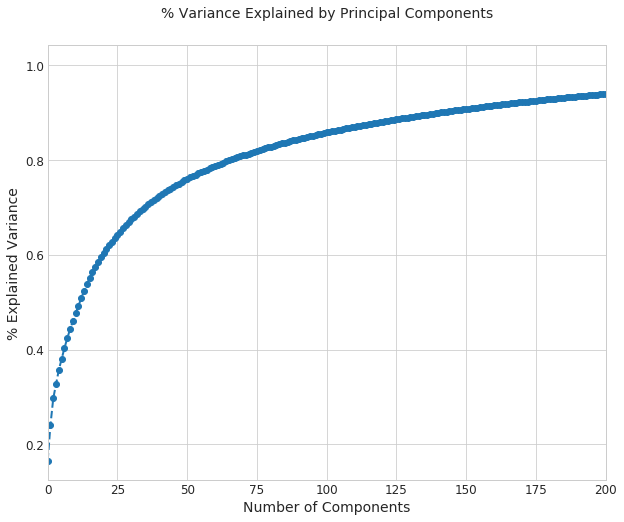

In [80]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [84]:
# np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0]

In [85]:
pca=PCA(n_components=66,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 66 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 66 components is: 0.798995155326


In [86]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [88]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,66).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.870052507139
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27648   190    27838
True        4042   687     4729
__all__    31690   877    32567

Accuracy of the model for test data is: 0.865757799067
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6897    43     6940
True        1050   152     1202
__all__     7947   195     8142



Logistic Regression
Accuracy of the model for training data is: 0.874259219455
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24595  3243    27838
True         852  3877     4729
__all__    25447  7120    32567

Accuracy of the model for test data is: 0.875829034635
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6134   806     6940
True         205   997     1202
__all__     6339  1803     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.903859735315
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24860  2978    27838
True         153  4576     4729
__all__    25013  7554    32567

Accuracy of the model for test data is: 0.892041267502
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6184   756     6940
True         123  1079     1202
__all__     6307  1835     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.885098412503
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24878  2960    27838
True         782  3947     4729
__all__    25660  6907    32567

Accuracy of the model for test data is: 0.884549250798
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6205   735     6940
True         205   997     1202
__all__     6410  1732     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.892713482974
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24899  2939    27838
True         555  4174     4729
__all__    25454  7113    32567

Accuracy of the model for test data is: 0.889707688529
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6199   741     6940
True         157  1045     1202
__all__     6356  1786     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.906377621519
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24874  2964    27838
True          85  4644     4729
__all__    24959  7608    32567

Accuracy of the model for test data is: 0.892901007124
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6188   752     6940
True         120  1082     1202
__all__     6308  1834     8142



Bagging Classifier
Accuracy of the model for training data is: 0.904136088679
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24868  2970    27838
True         152  4577     4729
__all__    25020  7547    32567

Accuracy of the model for test data is: 0.893146647015
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6189   751     6940
True         119  1083     1202
__all__     6308  1834     8142



Neural Network-1
The accuracy of the model on training data is: 0.895569134409


Predicted  False  True  __all__
Actual                         
False      24612  3226    27838
True         175  4554     4729
__all__    24787  7780    32567

The accuracy of the model on test data is: 0.886391549988


Predicted  False  True  __all__
Actual                         
False       6124   816     6940
True         109  1093     1202
__all__     6233  1909     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [89]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [90]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.870053,687.0,27648.0,190.0,4042.0,0.006825,0.854726
LogisticRegression,0.874259,3877.0,24595.0,3243.0,852.0,0.116495,0.180165
RandomForestClassifier,0.903860,4576.0,24860.0,2978.0,153.0,0.106976,0.032354
AdaBoostClassifier,0.885098,3947.0,24878.0,2960.0,782.0,0.106329,0.165363
GradientBoostingClassifier,0.892713,4174.0,24899.0,2939.0,555.0,0.105575,0.117361
ExtraTreeClassifier,0.906378,4644.0,24874.0,2964.0,85.0,0.106473,0.017974
BaggingClassifier,0.904136,4577.0,24868.0,2970.0,152.0,0.106689,0.032142
Neural Network-1,0.895569,4554.0,24612.0,3226.0,175.0,0.115885,0.037006


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.865758,152.0,6897.0,43.0,1050.0,0.006196,0.873544,0.560130,0.279019
LogisticRegression,0.875829,997.0,6134.0,806.0,205.0,0.116138,0.170549,0.856656,0.609402
RandomForestClassifier,0.892041,1079.0,6184.0,756.0,123.0,0.108934,0.102329,0.894368,0.669630
AdaBoostClassifier,0.884549,997.0,6205.0,735.0,205.0,0.105908,0.170549,0.861772,0.627182
GradientBoostingClassifier,0.889708,1045.0,6199.0,741.0,157.0,0.106772,0.130616,0.881306,0.653737
ExtraTreeClassifier,0.892901,1082.0,6188.0,752.0,120.0,0.108357,0.099834,0.895905,0.672368
BaggingClassifier,0.893147,1083.0,6189.0,751.0,119.0,0.108213,0.099002,0.896393,0.673197
Neural Network-1,0.886392,1093.0,6124.0,816.0,109.0,0.117579,0.090682,0.896393,0.662922


In [91]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')